# Rossman dataset 

Fuente lightgbm: https://lightgbm.readthedocs.io/en/stable/

https://www.kaggle.com/competitions/rossmann-store-sales/data

- Id - an Id that represents a (Store, Date) duple within the test set
- Store - a unique Id for each store
- Sales - the turnover for any given day (this is what you are predicting)
- Customers - the number of customers on a given day
- Open - an indicator for whether the store was open: 0 = closed, 1 = open
- StateHoliday - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None
- SchoolHoliday - indicates if the (Store, Date) was affected by the closure of public schools
- StoreType - differentiates between 4 different store models: a, b, c, d
- Assortment - describes an assortment level: a = basic, b = extra, c = extended
- CompetitionDistance - distance in meters to the nearest competitor store
- CompetitionOpenSince[Month/Year] - gives the approximate year and month of the time the nearest competitor was opened
- Promo - indicates whether a store is running a promo on that day
- Promo2 - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
- Promo2Since[Year/Week] - describes the year and calendar week when the store started participating in Promo2
- PromoInterval - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

In [3]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor, plot_importance
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

# ----------------------------
# CARGA Y PREPROCESAMIENTO
# ----------------------------
# Carga de datos
train = pd.read_csv('rossman.csv')
stores = pd.read_csv('store.csv')

# Merge de ambos datasets
df = pd.merge(train, stores, on='Store')

# Convertir la columna de fecha
df['Date'] = pd.to_datetime(df['Date'])

# Ordenar por fecha para evitar leakage
df = df.sort_values('Date')

# Filtrar solo tiendas abiertas
df = df[df['Open'] == 1]

# ----------------------------
# FEATURE ENGINEERING
# ----------------------------

# Variables temporales útiles
df['month'] = df['Date'].dt.month
df['day_of_month'] = df['Date'].dt.day
df['week_of_year'] = df['Date'].dt.isocalendar().week.astype(int)

# Eliminar columnas que no usaremos
df = df.drop(columns=['Date', 'Store', 'Customers', 'Open'])



C:\Users\ppmel\AppData\Local\Temp\ipykernel_21100\2846779669.py:11: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  train = pd.read_csv('rossman.csv')


In [4]:
# ----------------------------
# SEPARACIÓN TEMPORAL: 80% pasado, 20% futuro
# ----------------------------
split_index = int(len(df) * 0.8)
train_df = df.iloc[:split_index]
test_df = df.iloc[split_index:]

# Separar X y y
target = 'Sales'
X_train = train_df.drop(columns=target)
y_train = train_df[target]
X_test = test_df.drop(columns=target)
y_test = test_df[target]

# Codificar variables categóricas (después del split para evitar leakage)
X_train = pd.get_dummies(X_train, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)

# Alinear columnas en test con train
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

# Asegura que los nombres de columna sean strings y estén limpios
X_train.columns = X_train.columns.str.replace(r'[^\w]', '_', regex=True)

X_test.columns = X_test.columns.str.replace(r'[^\w]', '_', regex=True)


### ⚙️ Tuneando LightGBM

- **`num_iterations`** (`n_estimators` en `sklearn`):  
  Número total de árboles a entrenar. Si usas `early_stopping_rounds`, puedes poner un número alto sin preocuparte por overfitting.

- **`max_depth`**:  
  Profundidad máxima de cada árbol. Profundidades mayores capturan más complejidad, pero pueden sobreajustar.

- **`learning_rate`**:  
  Qué tan rápido aprende el modelo. Valores más bajos requieren más árboles, pero suelen generalizar mejor.

- **`subsample`** (`bagging_fraction`):  
  Fracción de observaciones usadas en cada árbol. Ayuda a reducir overfitting. Requiere activar también `bagging_freq`.

- **`feature_fraction`** (equivalente a `colsample_bytree` en XGBoost):  
  Fracción de columnas (features) usadas en cada árbol. También ayuda a evitar sobreajuste.

- **`early_stopping_rounds`**:  
  Detiene el entrenamiento si la métrica en el conjunto de validación no mejora en N iteraciones. Requiere `valid_sets` y `eval_metric`.

- **`metric`** (`eval_metric` en sklearn):  
  Métrica usada durante entrenamiento para monitorear desempeño (ej: `'rmse'`, `'mae'`, `'binary_logloss'`, `'auc'`).

- **`min_data_in_leaf`**:  
  Número mínimo de muestras requeridas en una hoja. Sirve para evitar sobreajuste. Similar a `min_child_samples` en XGBoost y `min_data_in_leaf` en CatBoost.

- **`lambda_l2`** (`reg_lambda` en sklearn):  
  Regularización L2 (Ridge) aplicada a los pesos de las hojas. Ayuda a controlar la complejidad.

- **`min_gain_to_split`** (`gamma` en XGBoost):  
  Ganancia mínima necesaria para hacer un split. Controla qué tan fácilmente el árbol se ramifica → útil contra overfitting.


    eval_set=[(X_train, y_train), (X_test, y_test)],
    callbacks=[
        early_stopping(20),
        log_evaluation(100)
    ]

In [5]:
from lightgbm import LGBMRegressor, early_stopping, log_evaluation
from sklearn.metrics import r2_score

# Definir modelo
model = LGBMRegressor(
    n_estimators=10000,
    num_leaves=10,
    max_depth=5,
    learning_rate=0.1,
    colsample_bytree=0.8, 
    subsample=0.8,              
    metric='rmse',
    verbosity=-1  
)

# Entrenar
model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    callbacks=[
        early_stopping(20),
        log_evaluation(100)
    ]
)

# Extraer resultados
results = model.evals_result_

# Predicción y métricas
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
print(f"R²: {r2:.4f}")
# Entrenar
model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    callbacks=[
        early_stopping(20),
        log_evaluation(100)
    ]
)

Training until validation scores don't improve for 20 rounds
[100]	training's rmse: 2247.8	valid_1's rmse: 2311.62
[200]	training's rmse: 2034.12	valid_1's rmse: 2111.21
[300]	training's rmse: 1878.92	valid_1's rmse: 1969.95
[400]	training's rmse: 1758.68	valid_1's rmse: 1860.77
[500]	training's rmse: 1671.47	valid_1's rmse: 1779.67
[600]	training's rmse: 1585.37	valid_1's rmse: 1701.58
[700]	training's rmse: 1495.36	valid_1's rmse: 1610.77
[800]	training's rmse: 1442.72	valid_1's rmse: 1560.81
[900]	training's rmse: 1390.66	valid_1's rmse: 1514.07
[1000]	training's rmse: 1343.31	valid_1's rmse: 1469.38
[1100]	training's rmse: 1304.87	valid_1's rmse: 1439.98
[1200]	training's rmse: 1272.82	valid_1's rmse: 1414.55
[1300]	training's rmse: 1249.67	valid_1's rmse: 1399.36
[1400]	training's rmse: 1226.28	valid_1's rmse: 1380.2
[1500]	training's rmse: 1201.03	valid_1's rmse: 1356.79
[1600]	training's rmse: 1180.22	valid_1's rmse: 1339.81
[1700]	training's rmse: 1160.9	valid_1's rmse: 1326.9


LGBMRegressor(colsample_bytree=0.8, max_depth=5, metric='rmse',
              n_estimators=10000, num_leaves=10, subsample=0.8, verbosity=-1)

### Cross validation 

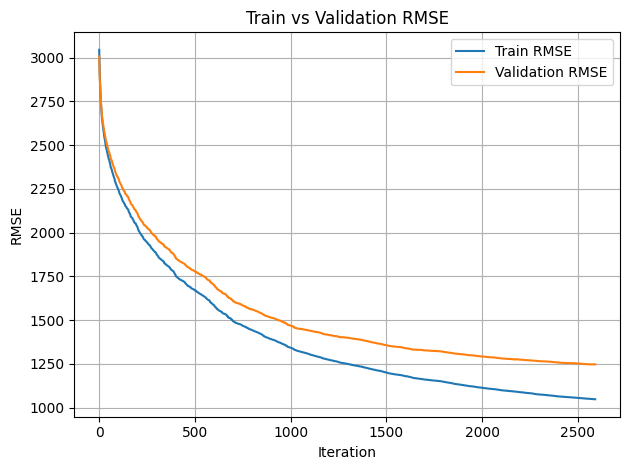

In [6]:
plt.plot(results['training']['rmse'], label='Train RMSE')
plt.plot(results['valid_1']['rmse'], label='Validation RMSE')
plt.xlabel('Iteration')
plt.ylabel('RMSE')

plt.title('Train vs Validation RMSE')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### ¿Donde convienre dar promociones?


In [7]:
ejemplo = X_test.iloc[[1]]
ejemplo

,DayOfWeek,Promo,SchoolHoliday,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,month,...,StateHoliday_a,StateHoliday_b,StateHoliday_c,StoreType_b,StoreType_c,StoreType_d,Assortment_b,Assortment_c,PromoInterval_Jan_Apr_Jul_Oct,PromoInterval_Mar_Jun_Sept_Dec
203883,5,1,0,390.0,2.0,2013.0,1,10.0,2014.0,1,...,False,False,0,False,False,False,False,False,True,False


¿Cuanto le voy a ganar a este ejemplo, si doy Promociones?

In [14]:
model.predict(ejemplo)[0]


8113.410674568001

In [15]:
ejemplo_contrafactural= ejemplo.copy()
ejemplo_contrafactural['Promo'] = 0

In [16]:
model.predict(ejemplo_contrafactural)[0]

6390.640819986537

Efecto

In [18]:
cate = model.predict(ejemplo)[0] - model.predict(ejemplo_contrafactural)[0]
cate

1722.7698545814637

## Conditional average treatment effect (CATE)

Para una covariable \( X = x \), el CATE se define como:

$$
\text{CATE}(x) = \mathbb{E}[Y(1) - Y(0) \mid X = x]
$$

> Es decir, **el efecto esperado del tratamiento para individuos con características \( X = x \)**.


## S-Learner

Entrenar un modelo, uno de los features es el tratamiento y probar diferentes contrafactuales

### Para todos los ejemplos que tienes, dime cual es el CATE 

In [20]:
# Pon 0 a todas las promos
x_test_counter0= X_test.copy()
x_test_counter0['Promo'] = 0

# Pon 1 toda las promos
x_test_counter1= X_test.copy()
x_test_counter1['Promo'] = 1


In [21]:
# Pon las predicciones en un df 

df_cate = pd.DataFrame({
    'treatment0': model.predict(x_test_counter0),
    'treatment1': model.predict(x_test_counter1)
})

In [22]:
# Calcula el CATE
df_cate['cate'] = df_cate['treatment1'] - df_cate['treatment0']

In [26]:
df_cate.cate.describe()

count    168879.000000
mean       2047.224937
std         862.939172
min        -632.711843
25%        1451.304008
50%        1808.664358
75%        2455.604710
max       10694.871872
Name: cate, dtype: float64

#### Supon que las promociones me cuetan, en promedio $2,000. ¿A quien le doy promoción?

In [27]:
# ¿A partir de cuanto incremento en ventas doy promoción?
np.mean(df_cate['cate']>2000)

0.40182615955802675

### T learner

In [28]:
# ----------------------------
# SEPARACIÓN TEMPORAL: 80% pasado, 20% futuro
# ----------------------------
split_index = int(len(df) * 0.8)
train_df = df.iloc[:split_index]
test_df = df.iloc[split_index:]

# Separar X y y
target = 'Sales'
X_train = train_df.drop(columns=target)
y_train = train_df[target]
X_test = test_df.drop(columns=target)
y_test = test_df[target]

# Codificar variables categóricas
X_train = pd.get_dummies(X_train, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)

# Alinear columnas
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)
X_train.columns = X_train.columns.str.replace(r'[^\w]', '_', regex=True)
X_test.columns = X_test.columns.str.replace(r'[^\w]', '_', regex=True)

# ----------------------------
# SEPARAR POR PROMO (entrenamiento y prueba)
# ----------------------------

# Detectar la columna codificada de Promo
promo_col = [col for col in X_train.columns if 'Promo' in col][0]  # asume binaria

# Train: Promo = 1
X_train_promo1 = X_train[X_train[promo_col] == 1]
y_train_promo1 = y_train.loc[X_train_promo1.index]

# Train: Promo = 0
X_train_promo0 = X_train[X_train[promo_col] == 0]
y_train_promo0 = y_train.loc[X_train_promo0.index]

# Test: Promo = 1
X_test_promo1 = X_test[X_test[promo_col] == 1]
y_test_promo1 = y_test.loc[X_test_promo1.index]

# Test: Promo = 0
X_test_promo0 = X_test[X_test[promo_col] == 0]
y_test_promo0 = y_test.loc[X_test_promo0.index]


In [39]:

model_t0= LGBMRegressor(
    n_estimators=10000,
    num_leaves=10,
    max_depth=5,
    learning_rate=0.1,
    colsample_bytree=0.8, 
    subsample=0.8,              
    metric='rmse',
    verbosity=-1  
)

model_t0.fit(
    X_train_promo0, y_train_promo0,
    eval_set=[(X_train_promo0, y_train_promo0), (X_test_promo0, y_test_promo0)],
    callbacks=[
        early_stopping(20),
        log_evaluation(100)
    ]
)


Training until validation scores don't improve for 20 rounds
[100]	training's rmse: 1972.53	valid_1's rmse: 2065.78
[200]	training's rmse: 1784	valid_1's rmse: 1897.39
[300]	training's rmse: 1643.12	valid_1's rmse: 1770.78
[400]	training's rmse: 1527.39	valid_1's rmse: 1661.31
[500]	training's rmse: 1424.94	valid_1's rmse: 1563.69
[600]	training's rmse: 1349.69	valid_1's rmse: 1488.68
[700]	training's rmse: 1279.62	valid_1's rmse: 1421.24
[800]	training's rmse: 1229.73	valid_1's rmse: 1373.17
[900]	training's rmse: 1186.04	valid_1's rmse: 1336.14
[1000]	training's rmse: 1149.27	valid_1's rmse: 1305.54
[1100]	training's rmse: 1117.09	valid_1's rmse: 1280.16
[1200]	training's rmse: 1089.46	valid_1's rmse: 1256.97
[1300]	training's rmse: 1063.18	valid_1's rmse: 1236.7
[1400]	training's rmse: 1040.88	valid_1's rmse: 1219.57
[1500]	training's rmse: 1021.57	valid_1's rmse: 1205.61
[1600]	training's rmse: 1001.88	valid_1's rmse: 1191.03
[1700]	training's rmse: 985.562	valid_1's rmse: 1177.82


LGBMRegressor(colsample_bytree=0.8, max_depth=5, metric='rmse',
              n_estimators=10000, num_leaves=10, subsample=0.8, verbosity=-1)

In [47]:
# Train model_t1 (Promo = 1)
model_t1 = LGBMRegressor(
    n_estimators=10000,
    num_leaves=10,
    max_depth=5,
    learning_rate=0.1,
    colsample_bytree=0.8, 
    subsample=0.8,              
    metric='rmse',
    verbosity=-1  
)

model_t1.fit(
    X_train_promo1, y_train_promo1,
    eval_set=[(X_train_promo1, y_train_promo1), (X_test_promo1, y_test_promo1)],
    callbacks=[
        early_stopping(20),
        log_evaluation(100)
    ]
)

# Predict treatment effects

Training until validation scores don't improve for 20 rounds
[100]	training's rmse: 2424.84	valid_1's rmse: 2483.82
[200]	training's rmse: 2168.79	valid_1's rmse: 2262.08
[300]	training's rmse: 1969.3	valid_1's rmse: 2087.94
[400]	training's rmse: 1816.69	valid_1's rmse: 1954.35
[500]	training's rmse: 1704.33	valid_1's rmse: 1865.39
[600]	training's rmse: 1610	valid_1's rmse: 1787.21
[700]	training's rmse: 1528.73	valid_1's rmse: 1714.26
[800]	training's rmse: 1461.74	valid_1's rmse: 1660.09
[900]	training's rmse: 1406.03	valid_1's rmse: 1611.71
[1000]	training's rmse: 1362.18	valid_1's rmse: 1579.76
Early stopping, best iteration is:
[1026]	training's rmse: 1352.12	valid_1's rmse: 1573


LGBMRegressor(colsample_bytree=0.8, max_depth=5, metric='rmse',
              n_estimators=10000, num_leaves=10, subsample=0.8, verbosity=-1)

### Juntar ambos 

In [48]:

todos = X_test.copy()
todos = todos[X_train_promo0.keys()]

df_cate = pd.DataFrame({
    'treatment0': model_t0.predict(todos),
    'treatment1': model_t1.predict(todos)
})

In [49]:
df_cate['cate'] = df_cate['treatment1'] - df_cate['treatment0'] 
df_cate


,treatment0,treatment1,cate
0,5273.524254,7915.119981,2641.595727
1,5944.481132,8540.208717,2595.727585
2,4609.464887,6423.846909,1814.382022
3,4471.117458,6456.110591,1984.993133
4,7277.334723,9877.798097,2600.463375
...,...,...,...
168874,6495.419271,8651.446339,2156.027068
168875,8258.529328,10434.039774,2175.510446
168876,5724.141283,7807.658725,2083.517442
168877,8370.313092,10043.400236,1673.087145


In [50]:
df_cate['bin_cate']= pd.qcut(df_cate['cate'], q=5, labels=False)+1

In [51]:
df_cate['Sales']= y_test

In [52]:
df_cate.groupby('bin_cate').mean()

,treatment0,treatment1,cate,Sales
bin_cate,,,,
1,6501.939459,6920.076871,418.137412,7146.882941
2,5698.490553,7038.491494,1340.000941,7191.109878
3,5623.735383,7541.862759,1918.127376,7233.211350
4,5720.519668,8348.290813,2627.771144,7190.764911
5,6012.723458,9982.534811,3969.811353,7203.094869
